In [1]:
import sys
import os
import pandas as pd
import scanpy as sc
from scipy import sparse
import numpy as np

from copulacci import cci
from copulacci import spatial
from copulacci import model
from copulacci import simulation
from copulacci import model2
import pickle
import importlib

/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!pwd

/Users/hs0424/Workspace/server_backup_code/copulacci/notebook/examples/visium_human_BRCA


# Copulacci runs

## Loading data

In [4]:
print("====Load Data===")
#parent_dir = '/n/fs/ragr-research/users/hirak/Projects/copulacci/notebook/examples/visium_human_BRCA/'
parent_dir = '/Users/hs0424/Workspace/server_backup_code/copulacci/notebook/examples/visium_human_BRCA/'
sample_name = 'V1_Breast_Cancer_Block_A_Section_1.h5ad'
adata = sc.read_h5ad(os.path.join(parent_dir, 'data', sample_name))
adata.var_names_make_unique()

====Load Data===


## Load SpatialDM labeled ligand receptor pairs for BRCA data

In [5]:
prefix = 'BRCA_disease_visium_sdm'
print('Filter ligand receptor pairs using SpatialDM filter', flush=True)
ligand_df = pd.read_csv(os.path.join(parent_dir, prefix + '_ligand.csv'),index_col=0)
receptor_df = pd.read_csv(os.path.join(parent_dir, prefix + '_receptor.csv'), index_col=0)
geneinter_df = pd.read_csv(os.path.join(parent_dir, prefix + '_geneInter.csv'), index_col=0)
ligand_df = ligand_df.where(pd.notna(ligand_df), None)
receptor_df = receptor_df.where(pd.notna(receptor_df), None)
geneinter_df = geneinter_df.where(pd.notna(geneinter_df), None)

Filter ligand receptor pairs using SpatialDM filter


## Find nearby edges in spatial adjacency graph

In [6]:
# Data preparation
print("====Data Preparation===")
count_df = adata.to_df()
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata,
    force_recalculate=True,
    distance_aware=False
)

====Data Preparation===
Constructing spatial network with visium


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3798/3798 [00:00<00:00, 10321.19it/s]


## Prepare datalist for running copulacci

In [7]:
data_list_dict, umi_sums, dist_list_dict, data_list_dict_selfloop, umi_sums_selfloop, dist_list_dict_selfloop = \
spatial.prepare_data_list_for_visium(
    count_df,
    int_edges_with_selfloop,
    lig_rec_info_df=geneinter_df,
    heteromeric=True,
    lig_df=ligand_df,
    rec_df=receptor_df,
    summarization='sum',
    separate_lig_rec_type=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


## Divide LR pairs in two groups close (annotated with 'Cell-Cell Contact') and distant

In [8]:
lig_rec_info_df=geneinter_df
close_contact_index = []
other_index = []
for index,row in lig_rec_info_df.iterrows():
    if row.annotation == 'Cell-Cell Contact':
        close_contact_index += [index]
    else:
        other_index += [index]

## Load pre-existing copula results for distant indices

In [9]:
def add_pvalue(row, bg_permutation_dict):
    if row.name in bg_permutation_dict:
        bg = bg_permutation_dict[row.name]
        if len(bg) < 100:
            return 1.0
        I = row.copula_coeff
        bg = np.append(bg, I)
        pval = np.sum(abs(bg) > abs(I))/len(bg)
        return pval
    return 1.0

In [10]:
import pickle
with open('copula_estimates.pkl', 'rb') as fp:
    copulacci_spatial_res = pickle.load(fp)
with open('copula_permutation.pkl', 'rb') as fp:
    copulacci_spatial_perm = pickle.load(fp)

### Load close interactions

In [11]:
import pickle
with open('copula_estimates_close.pkl', 'rb') as fp:
    copulacci_spatial_res_close = pickle.load(fp)
with open('copula_permutation_close.pkl', 'rb') as fp:
    copulacci_spatial_perm_close = pickle.load(fp)

### Calculate pvalues

In [12]:
from statsmodels.stats.multitest import multipletests
for ct in copulacci_spatial_res:
    copula_df = copulacci_spatial_res[ct].copy()
    copula_df['copula_pval'] = copula_df.apply(lambda row: add_pvalue(row,copulacci_spatial_perm[ct]), axis=1)
    if ct in copulacci_spatial_res_close:
        copula_df_close = copulacci_spatial_res_close[ct].copy()
        if ct in copulacci_spatial_perm_close:
            copula_df_close['copula_pval'] = copula_df_close.apply(lambda row: add_pvalue(row,copulacci_spatial_perm_close[ct]), axis=1)
        else:
            copula_df_close['copula_pval'] = 1.0
        copula_df = pd.concat([copula_df, copula_df_close])
    
    reject, pvals_corrected, _, _ = multipletests(
        copula_df.copula_pval, 
        alpha=0.05, 
        method='fdr_bh')
    copula_df['copula_pval_fdr'] = pvals_corrected
    copulacci_spatial_res[ct] = copula_df.copy()

# Spatial cross correlation runs

## Run Spatial Cross Correlation

In [11]:
adata_scc = adata.copy()

In [32]:
scc_df_dict = model2.run_scc(
    adata_scc,
    geneinter_df,
    int_edges_new,
    groups=list(data_list_dict.keys()),
    lig_df=ligand_df,
    rec_df=receptor_df,
    n_jobs=20,
    verbose=1,
    heteronomic=True,
    add_pval=True,
    use_spatialdm=True
)

Surrounding tumor=Surrounding tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   14.1s
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
/n/fs/ragr-data/users

Invasive=Invasive


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   32.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  5.2min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed: 12.9min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed: 23.8min
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed: 37.7min
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed: 40.8min finished


Healthy=Healthy


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.4s
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    9.9s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   22.8s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   40.9s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:  1.2min finished


Tumor=Tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    6.9s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   16.9s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   31.1s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   49.3s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:   53.3s finished


Surrounding tumor=Invasive


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   32.8s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  1.4min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  2.5min
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:  3.4min finished


Invasive=Surrounding tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   33.9s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  1.4min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  2.5min
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:  3.4min finished


Tumor=Invasive


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:    5.7s finished


Invasive=Tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:    5.7s finished


Tumor=Surrounding tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   16.5s
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:   22.6s finished


Surrounding tumor=Tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   16.3s
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:   22.5s finished


Healthy=Surrounding tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    5.7s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   10.3s
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:   14.2s finished


Surrounding tumor=Healthy


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    5.7s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   10.4s
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:   14.2s finished


Healthy=Invasive


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    4.9s
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:    6.6s finished


Invasive=Healthy


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    4.9s
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:    6.6s finished


Tumor=Healthy


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:    5.5s finished


Healthy=Tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:    5.5s finished


In [35]:
with open('scc_estimates.pickle', 'wb') as fp:
    pickle.dump(scc_df_dict, fp)

In [13]:
with open('scc_estimates.pickle', 'rb') as fp:
    scc_df_dict = pickle.load(fp)

In [14]:
scc_df_dict.keys()

dict_keys(['Surrounding tumor=Surrounding tumor', 'Invasive=Invasive', 'Healthy=Healthy', 'Tumor=Tumor', 'Surrounding tumor=Invasive', 'Invasive=Surrounding tumor', 'Tumor=Invasive', 'Invasive=Tumor', 'Tumor=Surrounding tumor', 'Surrounding tumor=Tumor', 'Healthy=Surrounding tumor', 'Surrounding tumor=Healthy', 'Healthy=Invasive', 'Invasive=Healthy', 'Tumor=Healthy', 'Healthy=Tumor'])

# SpatialDM runs

## Run SpatialDM for spatial cross correlation

In [33]:
adata_sdm = adata.copy()
adata_sdm.raw = adata_sdm.copy()
sc.pp.normalize_total(adata_sdm, target_sum=None)
sc.pp.log1p(adata_sdm)

In [57]:
sdm_df_dict = model.run_sdm(
    adata_sdm,
    int_edges_new,
    groups = list(data_list_dict.keys()),
    nproc = 20,
    heteronomic=True
)

Surrounding tumor=Surrounding tumor
Graph with 410 nodes and 945 edges
(410, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Surrounding tumor=Surrounding tumor  is  94.31083226203918  seconds
Invasive=Invasive
Graph with 1632 nodes and 4391 edges
(1632, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Invasive=Invasive  is  522.2735643386841  seconds
Healthy=Healthy
Graph with 364 nodes and 953 edges
(364, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Healthy=Healthy  is  68.31952166557312  seconds
Tumor=Tumor
Graph with 328 nodes and 844 edges
(328, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Tumor=Tumor  is  102.11750864982605  seconds
Surrounding tumor=Invasive
DiGraph with 610 nodes and 615 edges
(610, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Surrounding tumor=Invasive  is  161.83235025405884  seconds
Invasive=Surrounding tumor
DiGraph with 610 nodes and 615 edges
(610, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Invasive=Surrounding tumor  is  158.78491711616516  seconds
Tumor=Invasive
DiGraph with 34 nodes and 27 edges
(34, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Tumor=Invasive  is  47.33084225654602  seconds
Invasive=Tumor
DiGraph with 34 nodes and 27 edges
(34, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Invasive=Tumor  is  47.99576449394226  seconds
Tumor=Surrounding tumor
DiGraph with 244 nodes and 234 edges
(244, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Tumor=Surrounding tumor  is  95.90183234214783  seconds
Surrounding tumor=Tumor
DiGraph with 244 nodes and 234 edges
(244, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Surrounding tumor=Tumor  is  95.29552555084229  seconds
Healthy=Surrounding tumor
DiGraph with 170 nodes and 154 edges
(170, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Healthy=Surrounding tumor  is  61.806764364242554  seconds
Surrounding tumor=Healthy
DiGraph with 170 nodes and 154 edges
(170, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Surrounding tumor=Healthy  is  63.5066294670105  seconds
Healthy=Invasive
DiGraph with 60 nodes and 55 edges
(60, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Healthy=Invasive  is  49.37256669998169  seconds
Invasive=Healthy
DiGraph with 60 nodes and 55 edges
(60, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Invasive=Healthy  is  50.81548285484314  seconds
Tumor=Healthy
DiGraph with 26 nodes and 23 edges
(26, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Tumor=Healthy  is  46.01484131813049  seconds
Healthy=Tumor
DiGraph with 26 nodes and 23 edges
(26, 36601)


/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Healthy=Tumor  is  45.5906081199646  seconds


In [59]:
sdm_df_dict.keys()

dict_keys(['Surrounding tumor=Surrounding tumor', 'Invasive=Invasive', 'Healthy=Healthy', 'Tumor=Tumor', 'Surrounding tumor=Invasive', 'Invasive=Surrounding tumor', 'Tumor=Invasive', 'Invasive=Tumor', 'Tumor=Surrounding tumor', 'Surrounding tumor=Tumor', 'Healthy=Surrounding tumor', 'Surrounding tumor=Healthy', 'Healthy=Invasive', 'Invasive=Healthy', 'Tumor=Healthy', 'Healthy=Tumor'])

In [60]:
with open('spatialsdm_estimates.pickle', 'wb') as fp:
    pickle.dump(sdm_df_dict, fp)

In [15]:
with open('spatialsdm_estimates.pickle', 'rb') as fp:
    sdm_df_dict = pickle.load(fp)

## Merge the results

In [16]:
merged_res_dict = {}
for gpair in list(data_list_dict.keys()):
    tmp1 = scc_df_dict[gpair].copy()
    tmp2 = sdm_df_dict[gpair].copy()
    tmp3 = tmp1.join(tmp2[['global_I', 'global_pval']], how='inner')
    res = copulacci_spatial_res[gpair]
    res = res.loc[res.copula_method == 'copula']
    res = copulacci_spatial_res[gpair].join(tmp3, how='inner')
    merged_res_dict[gpair] = res.copy()

# Scatterplots for merged results

In [36]:
from copulacci import plots2
importlib.reload(plots2)

<module 'copulacci.plots2' from '/Users/hs0424/miniforge3/envs/copulacci/lib/python3.9/site-packages/copulacci/plots2.py'>

In [18]:
import itertools
score_pair = list(itertools.combinations(['copula_coeff', 'scc','global_I'],2))

In [19]:
gpair = 'Tumor=Surrounding tumor'
res = merged_res_dict[gpair]

In [21]:
res.loc[res.copula_pval < 0.05].sort_values(['copula_coeff'],ascending=False).head(10)

,copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval
CXCL13_CXCR3,0.419189,-11.907842,-11.449714,copula,0.005747,0.202820,0.045366,0.427146,0.036283,3.766664e-69
PGF_VEGFR1,0.393423,-11.708991,-10.850878,copula,0.025229,0.358494,-0.002369,0.970060,-0.031109,1.000000e+00
LTA_TNFRSF14,0.387477,-13.334958,-9.609165,copula,0.000000,0.000000,0.115044,0.009980,0.032635,2.876230e-56
ANGPTL2_TLR4,0.379550,-11.489131,-10.873101,copula,0.021053,0.357792,-0.012703,0.798403,-0.022056,1.000000e+00
WNT7B_FZD7_LRP5,0.361712,-12.182279,-10.385004,copula,0.030612,0.401786,0.030101,0.506986,-0.042381,1.000000e+00
CXCL11_CXCR3,0.345856,-11.147036,-11.449714,copula,0.008147,0.244399,0.221263,0.001996,0.041779,3.797488e-91
IL16_CD4,0.310180,-11.742327,-10.331299,copula,0.000000,0.000000,0.160414,0.001996,0.086913,0.000000e+00
BMP8B_BMPR1B_BMPR2,0.298288,-11.708991,-10.114713,copula,0.037924,0.420000,0.088654,0.067864,0.039677,2.212868e-82
BMP8B_ACVR1_BMPR2,0.264595,-11.708991,-9.734116,copula,0.009980,0.268693,0.135731,0.009980,0.072860,1.382743e-273
BTLA_TNFRSF14,0.252703,-13.873955,-9.609165,copula,0.022044,0.357792,0.040276,0.425150,0.031150,2.035929e-51


In [20]:
res.loc[res.copula_pval_fdr < 0.3].sort_values(['copula_coeff'],ascending=False).head(10)

,copula_coeff,mu_x,mu_y,copula_method,copula_pval,copula_pval_fdr,scc,scc_pval,global_I,global_pval
CXCL13_CXCR3,0.419189,-11.907842,-11.449714,copula,0.005747,0.202820,0.045366,0.427146,0.036283,3.766664e-69
LTA_TNFRSF14,0.387477,-13.334958,-9.609165,copula,0.000000,0.000000,0.115044,0.009980,0.032635,2.876230e-56
CXCL11_CXCR3,0.345856,-11.147036,-11.449714,copula,0.008147,0.244399,0.221263,0.001996,0.041779,3.797488e-91
IL16_CD4,0.310180,-11.742327,-10.331299,copula,0.000000,0.000000,0.160414,0.001996,0.086913,0.000000e+00
BMP8B_ACVR1_BMPR2,0.264595,-11.708991,-9.734116,copula,0.009980,0.268693,0.135731,0.009980,0.072860,1.382743e-273
TGFB3_ACVR1_TGFBR1,0.207117,-10.615858,-8.940115,copula,0.000000,0.000000,0.082981,0.087824,0.012603,1.220831e-09
PTN_SDC4,0.201171,-11.645477,-8.051856,copula,0.000000,0.000000,0.069755,0.195609,-0.034874,1.000000e+00
C3_ITGAM_ITGB2,0.191261,-8.614972,-8.901833,copula,0.000000,0.000000,0.118658,0.033932,0.007450,3.520243e-04
SEMA3C_NRP1_NRP2,0.191261,-9.408046,-8.627146,copula,0.000000,0.000000,0.113187,0.027944,-0.044785,1.000000e+00
AREG_EGFR_ERBB2,0.181351,-12.875426,-8.163554,copula,0.000000,0.000000,0.161604,0.001996,0.052635,1.179621e-143


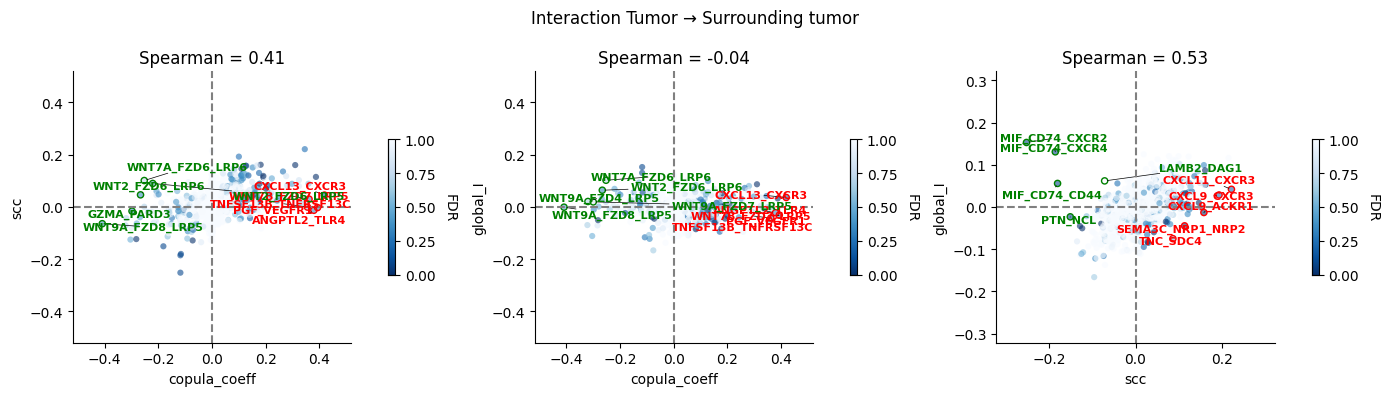

In [26]:
plots2.draw_pairwise_scatter_with_pval(
    merged_res_dict,
    'Tumor=Surrounding tumor',
    score_pair,
    ntop=5,
    center_plot=True,
    take_diff=True,
    fig_size = (14,4),
    force_static_pos=(0.3,1)
)

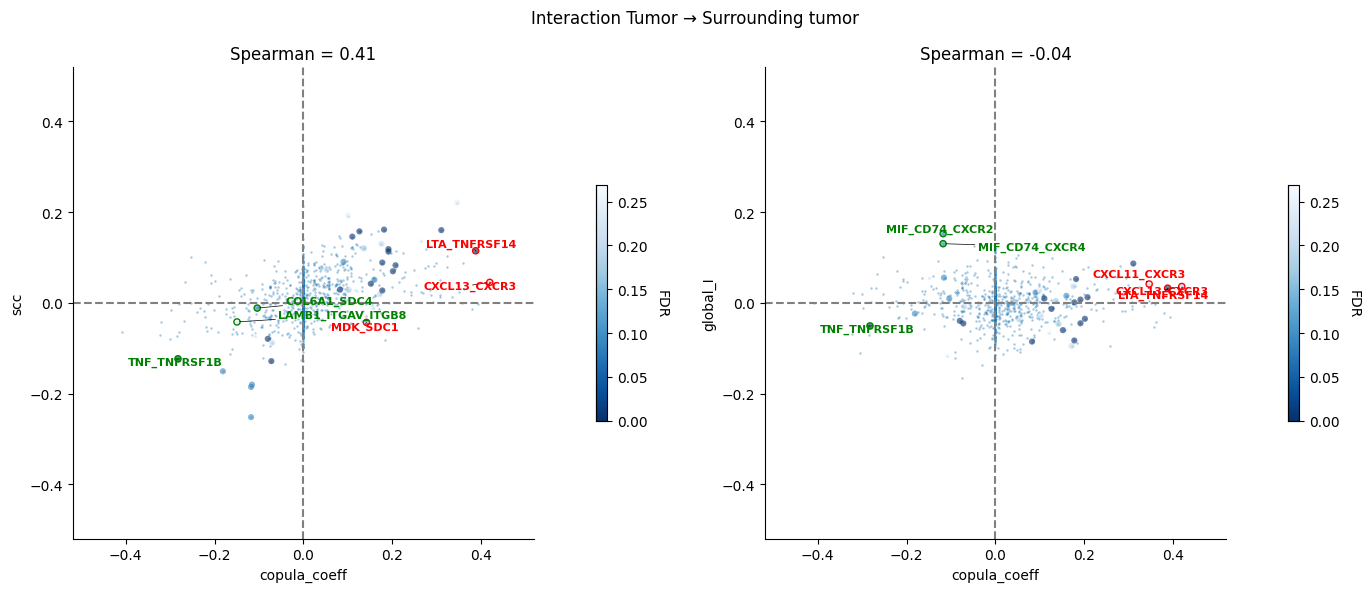

In [53]:
plots2.draw_pairwise_scatter_with_pval(
    merged_res_dict,
    'Tumor=Surrounding tumor',
    score_pair[:2],
    ntop=3,
    center_plot=True,
    take_diff=True,
    fig_size = (14,6),
    force_static_pos=(0.2,2),
    use_cutoff=True,
    cutoff=0.3
)

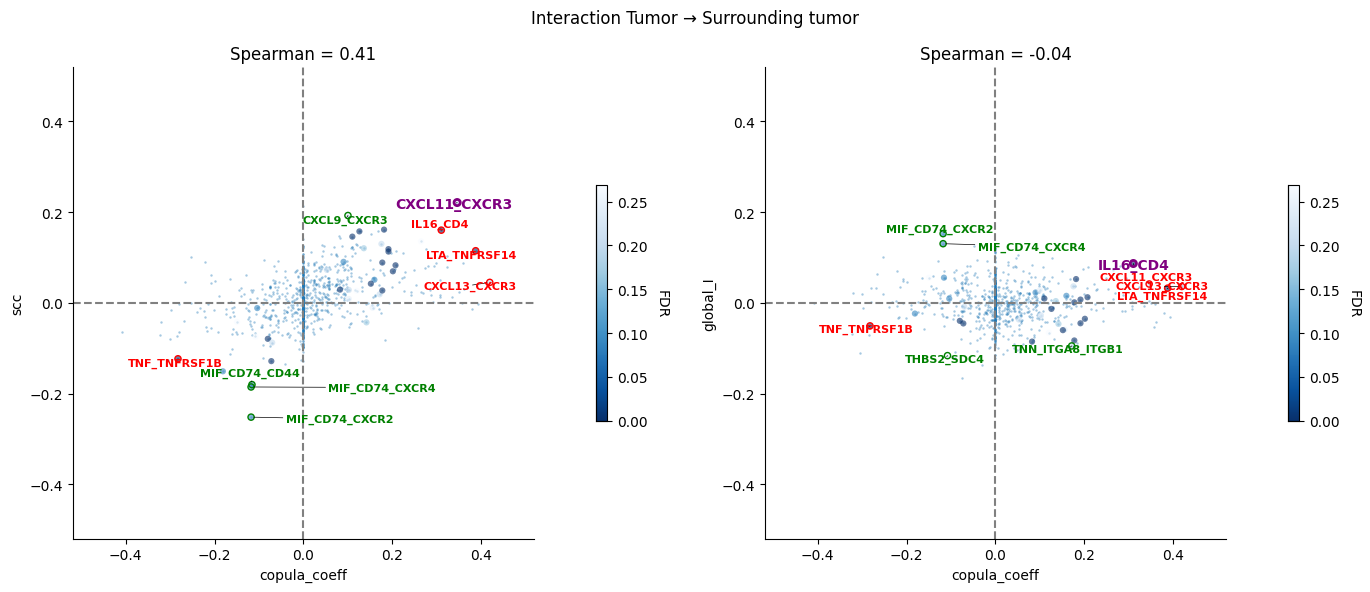

In [55]:
plots2.draw_pairwise_scatter_with_pval(
    merged_res_dict,
    'Tumor=Surrounding tumor',
    score_pair[:2],
    ntop=5,
    center_plot=True,
    #take_diff=True,
    fig_size = (14,6),
    force_static_pos=(0,1),
    use_cutoff=True,
    cutoff=0.3
)

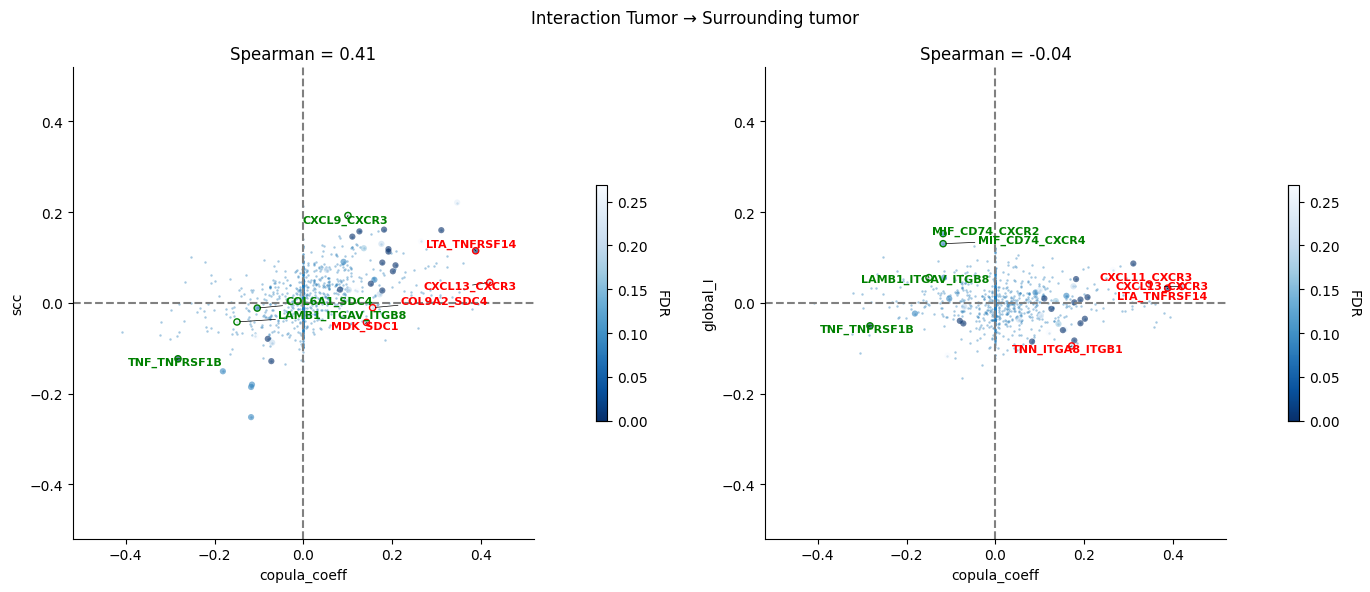

In [39]:
plots2.draw_pairwise_scatter_with_pval(
    merged_res_dict,
    'Tumor=Surrounding tumor',
    score_pair[:2],
    ntop=4,
    center_plot=True,
    take_diff=True,
    fig_size = (14,6),
    force_static_pos=(0,1),
    use_cutoff=True,
    cutoff=0.3
)

In [41]:
def linearize_to_df(cop_df_diff_gpairs, filter_copula=True):
    df = pd.DataFrame()
    for gpair in cop_df_diff_gpairs:
        tmp = cop_df_diff_gpairs[gpair].copy()
        if filter_copula:
            tmp = tmp.loc[tmp.copula_method == 'copula',:].copy()
        tmp.loc[:,'interaction'] = gpair
        tmp.loc[:,'LR_index'] = tmp.index
        tmp.index = list(range(tmp.shape[0]))
        df = pd.concat([df, tmp], axis = 0, ignore_index=True)
    return df

In [40]:
with open('copulacci_with_others_results.pkl', 'wb') as fp:
    pickle.dump(merged_res_dict, fp)

In [42]:
copulacci_merged_df = linearize_to_df(merged_res_dict)

In [44]:
copulacci_merged_df.to_csv('copulacci_with_other_results.csv', index=False)